In [11]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import librosa as lb
import soundfile as sf

1. Normalize
2. Cut into segments, 10.08/2 sec, and pad?
3. Re-save files
---
4. Figure out data shape
5. Train and 10-fold CV test

## Standardize data:
* Normalized $\in[-1,1]$
* Split into ~5 second segments with padding as necessary

In [2]:
# half the num samples in shortest songs
seg_len = 111132

In [3]:
folders = glob('data\\MER_taffc_as_wav\\*')
paths = []
for folder in folders:
    directory = folder + '\\*.wav'
    paths += glob(directory)
for path in tqdm(paths):
    y, sr = lb.load(path)
    y_norm = y/abs(y).max()
    n = int(np.ceil(y.shape[0]/seg_len))
    for j in range(n):
        seg = y_norm[seg_len*j:seg_len*(j+1)]
        pad = seg_len - seg.shape[0]
        if pad > 0:
            seg = np.concatenate((seg, np.zeros(pad)))
        seg = seg/abs(seg).max()
        split = path.split('\\')
        split[1] = 'MER_taffc_standard'
        split[3] = split[3][:-4] + f'-{j}.wav'
        dest = '\\'.join(split)
        sf.write(dest, seg, sr)

  0%|          | 0/900 [00:00<?, ?it/s]

## Load in standardized data:

In [2]:
folders = glob('data\\MER_taffc_standard\\*')
paths = []
for folder in folders:
    directory = folder + '\\*.wav'
    paths += glob(directory)
print(f'Number of segments: {len(paths)}')
segs = []
qs = []
for path in tqdm(paths):
    seg, sr = lb.load(path)
    segs.append(seg)
    qs.append(path.split('\\')[2])

Number of segments: 5392


  0%|          | 0/5392 [00:00<?, ?it/s]

In [13]:
qs = np.array(qs)

In [9]:
def quadrant_dist(qs):
    dist = {
        'Q1': 0,
        'Q2': 0,
        'Q3': 0,
        'Q4': 0
    }
    for q in qs:
        dist[q] += 1
    return dist

In [10]:
quadrant_dist(qs)

{'Q1': 1342, 'Q2': 1350, 'Q3': 1350, 'Q4': 1350}

In [11]:
n = segs[0].shape[0]
percent_zero = np.array([100*(seg == 0).sum()/n for seg in segs])

In [16]:
less_30 = qs[percent_zero <= 25]
quadrant_dist(less_30)

{'Q1': 1337, 'Q2': 1347, 'Q3': 1345, 'Q4': 1342}

In [21]:
np.sort(percent_zero)[::-1][0:10]

array([92.73026671, 85.3462549 , 64.63214916, 63.05024655, 61.49713854,
       61.49443905, 61.48544074, 61.43684987, 61.09491416, 60.92574596])

In [33]:
shapes = np.zeros((len(segs), 2))
i = 0
for seg in tqdm(segs):
    fft = lb.feature.melspectrogram(y=seg)
    shapes[i, 0] = fft.shape[0]; shapes[i, 1] = fft.shape[1]
    i += 1

  0%|          | 0/5392 [00:00<?, ?it/s]

In [38]:
shapes[:, 0].std(), shapes[:, 1].std(), fft.shape

(0.0, 0.0, (128, 218))

### Shape: 128x218

In [33]:
segs_list = [segs]
seg_i = np.random.randint(0, high=len(segs))
seg = segs[seg_i]

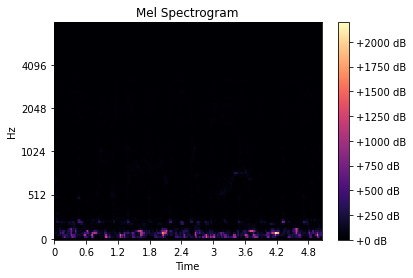

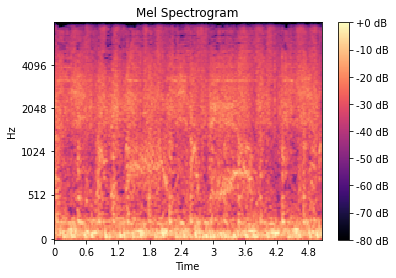

In [34]:
spec = lb.feature.melspectrogram(y=seg)
specshow(spec, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.figure()
spec = lb.power_to_db(spec, ref=np.max)
specshow(spec, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [29]:
from librosa.display import specshow